In [1]:
from torch.optim import Adam
from basic.transforms import aug_config
from OCR.ocr_dataset_manager import OCRDataset, OCRDatasetManager
from OCR.document_OCR.dan.trainer_dan import Manager
from OCR.document_OCR.dan.models_dan import GlobalHTADecoder
from basic.models import FCN_Encoder
from basic.scheduler import exponential_dropout_scheduler, linear_scheduler
import torch
import numpy as np
import random

dataset_name = "READ_2016"  # ["RIMES", "READ_2016"]
dataset_level = "page"  # ["page", "double_page"]
dataset_variant = "_sem"

# max number of lines for synthetic documents
max_nb_lines = {
	"RIMES": 40,
	"READ_2016": 30,
}

dataset_params = {
			"dataset_manager": OCRDatasetManager,
			"dataset_class": OCRDataset,
			"use_ddp": False,
			"batch_size": 1,
			"valid_batch_size": 4,
			"test_batch_size": 4,
			"num_gpu": torch.cuda.device_count(),
			"worker_per_gpu": 4,
			"datasets": {
				dataset_name: "/home/yukinori/Desktop/RenAIssance2025/DAN/Datasets/formatted/{}_{}{}".format(dataset_name, dataset_level, dataset_variant),
			},
			"train": {
				"name": "{}-train".format(dataset_name),
				"datasets": [(dataset_name, "train"), ],
			},
			"valid": {
				"{}-valid".format(dataset_name): [(dataset_name, "valid"), ],
			},
			"config": {
				"load_in_memory": True,  # Load all images in CPU memory
				"worker_per_gpu": 4,  # Num of parallel processes per gpu for data loading
				"width_divisor": 8,  # Image width will be divided by 8
				"height_divisor": 32,  # Image height will be divided by 32
				"padding_value": 0,  # Image padding value
				"padding_token": None,  # Label padding value
				"charset_mode": "seq2seq",  # add end-of-transcription ans start-of-transcription tokens to charset
				"constraints": ["add_eot", "add_sot"],  # add end-of-transcription ans start-of-transcription tokens in labels
				"normalize": False,  # Normalize with mean and variance of training dataset
				"preprocessings": [
					{
						"type": "to_RGB",
						# if grayscaled image, produce RGB one (3 channels with same value) otherwise do nothing
					},
				],
				"augmentation": aug_config(0.9, 0.1),
				# "synthetic_data": None,
				"synthetic_data": {
					"init_proba": 0.9,  # begin proba to generate synthetic document
					"end_proba": 0.2,  # end proba to generate synthetic document
					"num_steps_proba": 200000,  # linearly decrease the percent of synthetic document from 90% to 20% through 200000 samples
					"proba_scheduler_function": linear_scheduler,  # decrease proba rate linearly
					"start_scheduler_at_max_line": True,  # start decreasing proba only after curriculum reach max number of lines
					"dataset_level": dataset_level,
					"curriculum": True,  # use curriculum learning (slowly increase number of lines per synthetic samples)
					"crop_curriculum": True,  # during curriculum learning, crop images under the last text line
					"curr_start": 0,  # start curriculum at iteration
					"curr_step": 10000,  # interval to increase the number of lines for curriculum learning
					"min_nb_lines": 1,  # initial number of lines for curriculum learning
					"max_nb_lines": max_nb_lines[dataset_name],  # maximum number of lines for curriculum learning
					"padding_value": 255,
					# config for synthetic line generation
					"config": {
						"background_color_default": (255, 255, 255),
						"background_color_eps": 15,
						"text_color_default": (0, 0, 0),
						"text_color_eps": 15,
						"font_size_min": 35,
						"font_size_max": 45,
						"color_mode": "RGB",
						"padding_left_ratio_min": 0.00,
						"padding_left_ratio_max": 0.05,
						"padding_right_ratio_min": 0.02,
						"padding_right_ratio_max": 0.2,
						"padding_top_ratio_min": 0.02,
						"padding_top_ratio_max": 0.1,
						"padding_bottom_ratio_min": 0.02,
						"padding_bottom_ratio_max": 0.1,
					},
				}
			}
		}

my_dataset = dataset_params["dataset_manager"](dataset_params)
my_dataset.load_datasets()
my_dataset.load_ddp_samplers()
my_dataset.load_dataloaders()
my_dataset.train_dataset.training_info = {
	"epoch": 0,
	"step": 0,
}

In [2]:
sample_data = next(iter(my_dataset.train_loader))

In [3]:
sample_data

{'names': ['synthetic_data_0'],
 'ids': [0],
 'nb_lines': [1],
 'nb_cols': [1],
 'labels': tensor([[100,  97,  96,  10,  12,  91,  92,  99]]),
 'reverse_labels': tensor([[100,  92,  91,  12,  10,  96,  97,  99]]),
 'raw_labels': ['ⓟⓝ13ⓃⓅ'],
 'unchanged_labels': ['ⓟⓝ13ⓃⓅ'],
 'labels_len': [7],
 'imgs': tensor([[[[120., 120., 120.,  ..., 120., 120., 120.],
           [120., 120., 120.,  ..., 120., 120., 120.],
           [120., 120., 120.,  ..., 120., 120., 120.],
           ...,
           [120., 120., 120.,  ..., 120., 120., 120.],
           [120., 120., 120.,  ..., 120., 120., 120.],
           [120., 120., 120.,  ..., 120., 120., 120.]],
 
          [[120., 120., 120.,  ..., 120., 120., 120.],
           [120., 120., 120.,  ..., 120., 120., 120.],
           [120., 120., 120.,  ..., 120., 120., 120.],
           ...,
           [120., 120., 120.,  ..., 120., 120., 120.],
           [120., 120., 120.,  ..., 120., 120., 120.],
           [120., 120., 120.,  ..., 120., 120., 120.]],
 


In [4]:
print(sample_data["imgs"].shape)

torch.Size([1, 3, 57, 1221])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


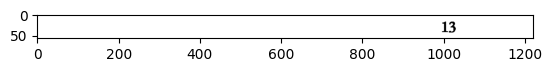

In [5]:
from matplotlib import pyplot as plt
plt.imshow(sample_data["imgs"][0].permute(1, 2, 0))

In [6]:
my_dataset.charset

['\n',
 ' ',
 '(',
 ')',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '¬',
 '¾',
 'Ö',
 'ß',
 'ä',
 'ö',
 'ü',
 'ÿ',
 'ā',
 'ē',
 'ō',
 'ū',
 'ȳ',
 '̄',
 '̈',
 '—',
 'Ⓐ',
 'Ⓑ',
 'Ⓝ',
 'Ⓟ',
 'Ⓢ',
 'ⓐ',
 'ⓑ',
 'ⓝ',
 'ⓟ',
 'ⓢ']

In [7]:
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
	"microsoft/swin-tiny-patch4-window7-224",
	"distilbert/distilgpt2",
	decoder_ignore_mismatched_sizes=True,
	decoder_vocab_size=10,
	encoder_image_size=(2560, 1920),
).to("cuda")

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilbert/distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transfo

In [8]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
processor.size = [2560, 1920]

In [10]:
def resize_with_padding(image_tensor, target_size, padding_value=0):
	"""
	Resize a PyTorch tensor image while maintaining the aspect ratio by adding padding.

	Args:
		image_tensor (torch.Tensor): The input image tensor of shape (C, H, W).
		target_size (tuple): The target size as (target_height, target_width).
		padding_value (int): The value to use for padding.

	Returns:
		torch.Tensor: The resized image tensor with padding.
	"""
	_, original_height, original_width = image_tensor.shape
	target_height, target_width = target_size

	# Calculate the scaling factor
	scale = min(target_width / original_width, target_height / original_height)
	new_width = int(original_width * scale)
	new_height = int(original_height * scale)

	# Resize the image
	resized_image = torch.nn.functional.interpolate(
		image_tensor.unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=False
	).squeeze(0)

	# Calculate padding
	pad_top = (target_height - new_height) // 2
	pad_bottom = target_height - new_height - pad_top
	pad_left = (target_width - new_width) // 2
	pad_right = target_width - new_width - pad_left

	# Apply padding
	padded_image = torch.nn.functional.pad(
		resized_image, (pad_left, pad_right, pad_top, pad_bottom), value=padding_value
	)

	return padded_image

# Example usage
target_size = (2560, 1920)
resized_image = resize_with_padding(sample_data["imgs"][0], target_size, padding_value=120)

In [11]:
resized_image.size()

torch.Size([3, 2560, 1920])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


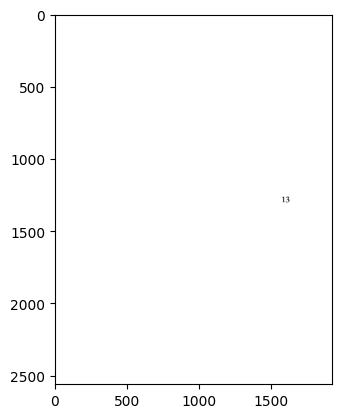

In [12]:
plt.imshow(resized_image.permute(1, 2, 0))

In [13]:
print(torch.min(resized_image), torch.max(resized_image))

tensor(0.) tensor(159.6405)


In [14]:
resized_image = resized_image.int()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


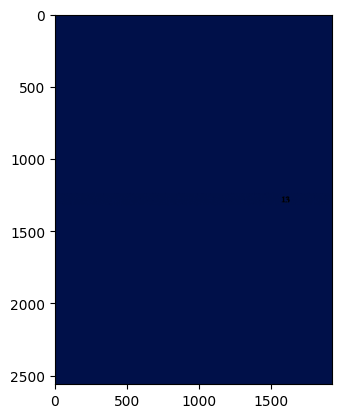

In [15]:
input_sample = processor(resized_image, return_tensors="pt")
plt.imshow(np.transpose(input_sample["pixel_values"][0], (1, 2, 0)))

In [16]:
type(input_sample)

transformers.image_processing_base.BatchFeature

In [17]:
model.device

device(type='cuda', index=0)

In [18]:
input_sample.to("cuda")

{'pixel_values': tensor([[[[-0.0629, -0.0629, -0.0629,  ..., -0.0629, -0.0629, -0.0629],
          [-0.0629, -0.0629, -0.0629,  ..., -0.0629, -0.0629, -0.0629],
          [-0.0629, -0.0629, -0.0629,  ..., -0.0629, -0.0629, -0.0629],
          ...,
          [-0.0629, -0.0629, -0.0629,  ..., -0.0629, -0.0629, -0.0629],
          [-0.0629, -0.0629, -0.0629,  ..., -0.0629, -0.0629, -0.0629],
          [-0.0629, -0.0629, -0.0629,  ..., -0.0629, -0.0629, -0.0629]],

         [[ 0.0651,  0.0651,  0.0651,  ...,  0.0651,  0.0651,  0.0651],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.0651,  0.0651,  0.0651],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.0651,  0.0651,  0.0651],
          ...,
          [ 0.0651,  0.0651,  0.0651,  ...,  0.0651,  0.0651,  0.0651],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.0651,  0.0651,  0.0651],
          [ 0.0651,  0.0651,  0.0651,  ...,  0.0651,  0.0651,  0.0651]],

         [[ 0.2871,  0.2871,  0.2871,  ...,  0.2871,  0.2871,  0.2871],
          [ 0

In [19]:
output = model(**input_sample)

OutOfMemoryError: CUDA out of memory. Tried to allocate 114.00 MiB. GPU 0 has a total capacity of 7.61 GiB of which 78.31 MiB is free. Including non-PyTorch memory, this process has 7.51 GiB memory in use. Of the allocated memory 7.22 GiB is allocated by PyTorch, and 180.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)